# 03 - Hero Lane Outcomes
Extraction des stats early game par lane/hero.


In [1]:
import sys
from pathlib import Path

def _find_root():
    cand = Path.cwd()
    for c in [cand, *cand.parents]:
        if (c / 'src').exists() and (c / 'data').exists():
            return c
    return cand

ROOT = _find_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

processed_dir = ROOT / 'data/processed'
parquet_paths = [processed_dir / f for f in ['matches.parquet', 'players.parquet', 'objectives.parquet', 'teamfights.parquet']]
missing = [p for p in parquet_paths if not p.exists()]
if missing:
    raise FileNotFoundError(f"Parquets manquants: {missing}. Regenerer avec `make parquet`.")

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.dota_data import read_processed_tables, lane_phase_features, match_header

sns.set_theme(style='whitegrid')

tables = read_processed_tables(processed_dir)
matches = match_header(tables['matches'])
players = tables['players']

minute = 10
lane_feats = lane_phase_features(players, minute=minute)
lane_df = lane_feats.to_pandas()
lane_df.head()
display(lane_df.shape)


(141700, 12)

In [2]:
lane_df

,match_id,player_slot,is_radiant,hero_id,lane,lane_role,gpm,xpm,lh_m10,dn_m10,gold_m10,xp_m10
0,8572758153,0,True,52,2.0,2.0,725,825,58.0,7.0,5016.0,4423.0
1,8572758153,1,True,129,3.0,3.0,527,684,37.0,8.0,3295.0,3443.0
2,8572758153,2,True,102,1.0,1.0,727,763,54.0,19.0,3824.0,3963.0
3,8572758153,3,True,100,2.0,2.0,375,581,10.0,0.0,2095.0,2070.0
4,8572758153,4,True,64,1.0,1.0,351,544,7.0,5.0,2107.0,2229.0
...,...,...,...,...,...,...,...,...,...,...,...,...
141695,7999196876,128,False,58,3.0,1.0,382,496,10.0,0.0,1868.0,2285.0
141696,7999196876,129,False,38,1.0,3.0,571,493,59.0,14.0,4446.0,3803.0
141697,7999196876,130,False,17,2.0,2.0,553,679,51.0,9.0,3932.0,4568.0
141698,7999196876,131,False,119,1.0,3.0,339,449,13.0,0.0,2918.0,2696.0


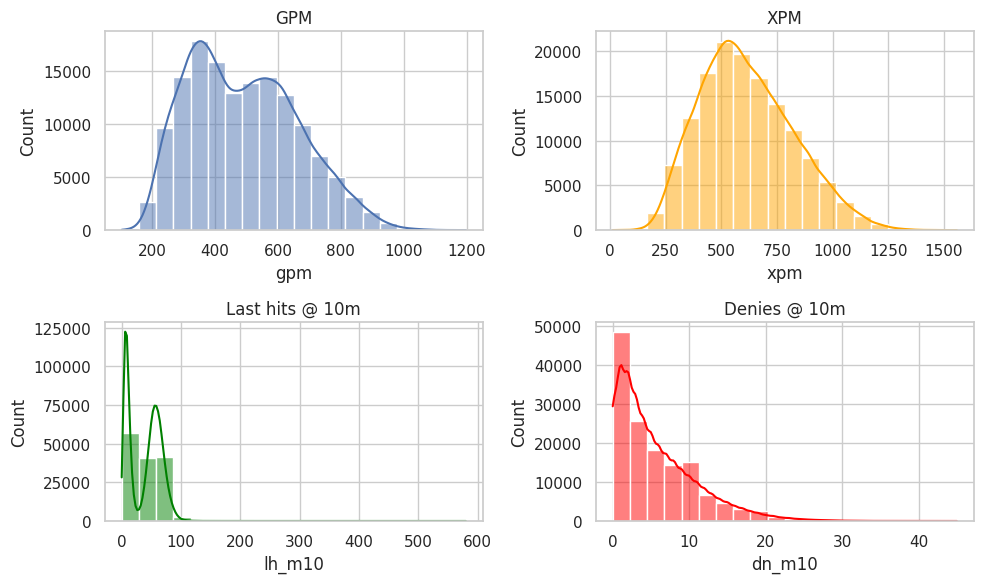

In [3]:
# Distributions GPM/XPM et LH/DN à 10 min
fig, axes = plt.subplots(2,2, figsize=(10,6))
sns.histplot(lane_df['gpm'].dropna(), bins=20, ax=axes[0,0], kde=True)
axes[0,0].set_title('GPM')
sns.histplot(lane_df['xpm'].dropna(), bins=20, ax=axes[0,1], kde=True, color='orange')
axes[0,1].set_title('XPM')
sns.histplot(lane_df[f'lh_m{minute}'].dropna(), bins=20, ax=axes[1,0], kde=True, color='green')
axes[1,0].set_title(f'Last hits @ {minute}m')
sns.histplot(lane_df[f'dn_m{minute}'].dropna(), bins=20, ax=axes[1,1], kde=True, color='red')
axes[1,1].set_title(f'Denies @ {minute}m')
plt.tight_layout()
plt.show()


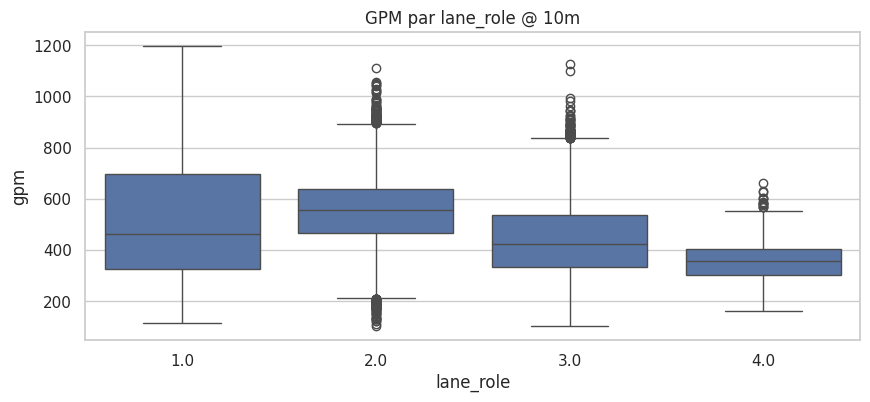

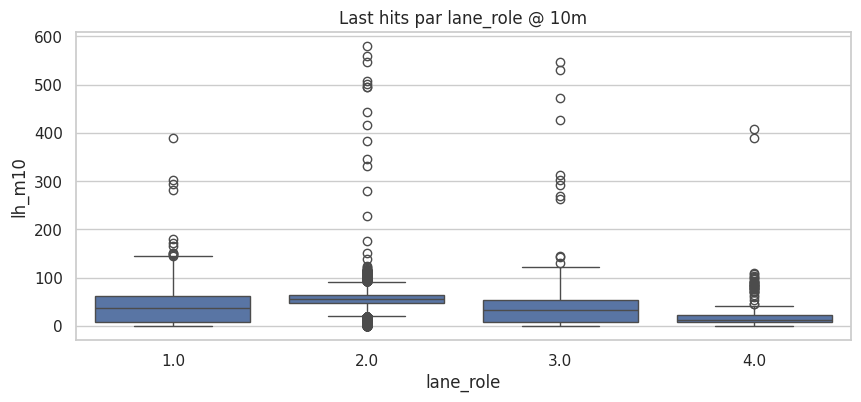

In [4]:
# Comparaison par lane_role (1=safe, 2=mid, 3=offlane, 4/5 supports)
plt.figure(figsize=(10,4))
sns.boxplot(data=lane_df, x='lane_role', y='gpm')
plt.title(f'GPM par lane_role @ {minute}m')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=lane_df, x='lane_role', y=f'lh_m{minute}')
plt.title(f'Last hits par lane_role @ {minute}m')
plt.show()


In [5]:
# Top 10 heros par GPM moyen
top_gpm = lane_df.groupby('hero_id')['gpm'].mean().sort_values(ascending=False).head(10)
top_gpm


hero_id
73    768.481243
48    750.091083
94    741.125405
46    709.753491
82    707.246377
1     705.975078
8     698.583569
12    694.766990
44    685.240395
10    682.029058
Name: gpm, dtype: float64